## Is the Lamprey River hydrograph shape changing due to vernal window protraction? 

Deni Murray; 
ESCI 895 final project

#### ***Edits still to be done on this notebook***
1. show example of a year or season w/ a high RB index and low RB index
2. what is the typical range for RB index? (eg what is high vs. low)
3. Annotate the water year hydrographs with the RB index
4. Pearson correlation coefficient run on timeseries data
5. Interpretation of figures in section 3.5+
7. Foreshadow in the text what the overall story is -- how do all the analyses fit together?
8. Increase font size in figure 5
10. define 'shape of the hydrograph' -- what does it mean and its different dimensions
11. describe how snowmelt and rainmelt periods may be expected to differ how results fit into those predictions
12. figure captions on next line as figure (currently on same line)
13. Expand discussion
14. Expand conclusion

### 1. Introduction
Over the last century, climate change has altered New England seasonality (Hayhoe et al., 2008). Increased air temperature has resulted in warmer winters wherein less precipitation falls as snow, and rain-on-snow events are increasingly common. Recent research describes this phenomenon as the protraction of the vernal window – the period between winter and spring (Contosta et al., 2017; Contosta et al., 2019). A cold-winter snowmelt hydrograph generally reflects low winter baseflow with a peaked spring freshet in the vernal window (Figure 1). However, due to vernal window protraction, the winter-spring hydrograph may be evolving into a flashier, or multi-peaked hydrograph, with multiple snowmelt events (Figure 1; Creed et al., 2015, Grogan et al., 2020). The shift towards a flashier winter-spring hydrograph can change the annual water distribution, in-stream biogeochemical processing and aquatic phenology (Contosta et al., 2017; Coble et al., 2019). Here, daily discharge data from the Lamprey River watershed in New Hampshire, USA were used to determine whether the shape of the hydrograph has changed from 1990 to 2020. Results from this study will inform whether climate change in the northeast is affecting river discharge. 

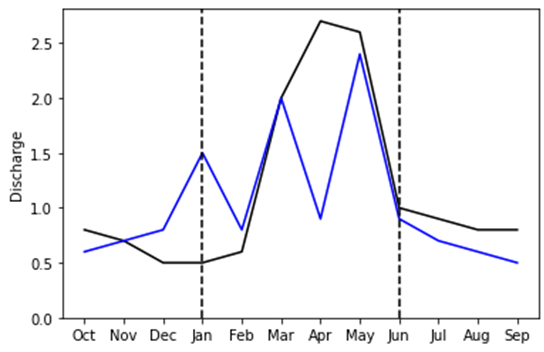
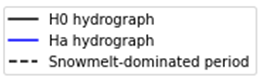
Figure 1. Hypothetical water year hydrographs for a cold-winter hydrograph (H0, black) and warm-winter hydrograph (Ha, blue).


### 2. Methods
### 2.1 Site Description
The Lamprey River is a 5th order river that is located in southeastern New Hampshire (USA) and drains into the Great Bay Estuary (Figure 2). The Lamprey River watershed drains 554 km^2 of suburbanized low-elevation (6.2% average slope) terrain that remains heavily forested (73%) and contains many wetland complexes (10%) (Wymore et al., 2021). Mean annual temperature is 8.1 °C, mean annual precipitation is 114 cm, and mean annual snowfall is 167 cm. Snow-precipitation typically occurs from October to March.

Daily discharge data was collected for the mainstem of the Lamprey River in New Hampshire from the U.S. Geological Survey (USGS) gaging station 01073500 (Figure 1). This gage captures 479 km^2 (86%) of the Lamprey River drainage area. Two dams exist on the lower Lamprey River (Figure 2), one upstream of the gage 01073500 (Wiswall Falls) and one downstream of gage 01073500 (Macallen Dam). Daily precipitation data was collected for Durham, New Hampshire from the National Oceanic Atmospheric Administration Global Hourly Climate National Data (NOAA GHCND) gaging station USC00272174. The USGS gage and NOAA GHCND gage are located approximately 4 km apart, and are both situated at less than 20 m asl (Figure 2). 

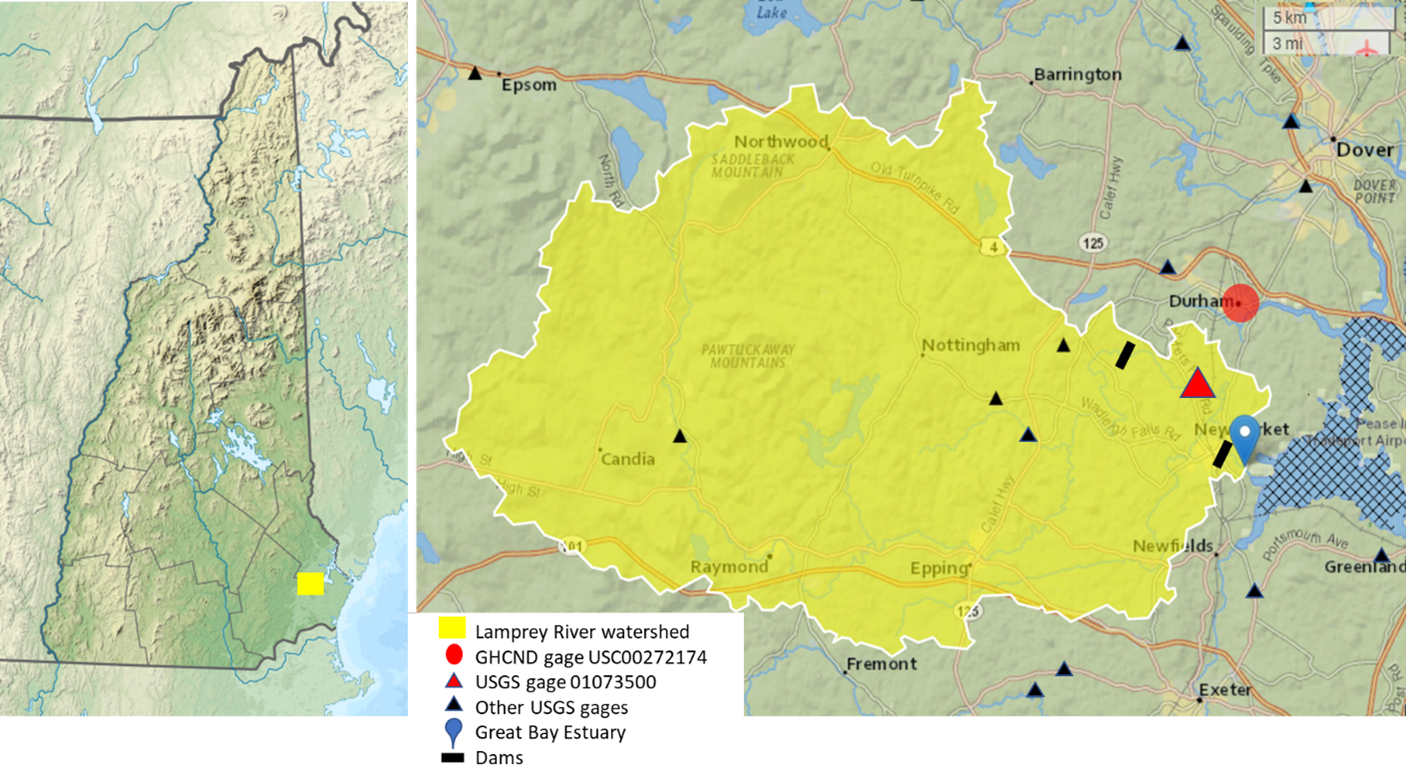
Figure 2. Lamprey River watershed (yellow) with the USGS Lamprey River at Newmarket gage (01073500) noted with the red triangle and the GHCND NCDC gage USC00272174 is noted with the red circle. Image from StreamStats.


### 2.2 Data cleaning

To determine whether the shape of the Lamprey River hydrograph has changed over the past 30 years, daily discharge and precipitation (total and snow-derived) data from October 1st, 1990 – September 30th, 2020 were downloaded directly from USGS and NOAA GHCND, respectively. Data analysis was conducted in Python (3.8.8). Missing discharge data was lineraly interpolated and missing precipitation data was assigned a zero.

In [ ]:
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import datetime
from dateutil.parser import parse
from datetime import datetime, date, time 
import matplotlib.image as mpimg


In [ ]:
#Define functions
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [ ]:
# Specify inputs
fileNames = ['lamprey_daily_discharge.txt', 'Durham PRCP SNOW.csv']     
river = 'Lamprey River, NH'             

In [ ]:
#Load and clean discharge data
dfdaily = pd.read_csv(fileNames[0],delimiter="\t",comment='#',header=0)
dfdaily = dfdaily.iloc[1:]     # remove first row 
dfdaily['datetime'] = pd.to_datetime(dfdaily['datetime'], format='%Y-%m-%d')
dfdaily.set_index(['datetime'], inplace = True)
dfdaily = dfdaily.filter(like='00060',axis=1)
dfdaily = dfdaily.iloc[:, 0].to_frame() 
dfdaily.rename(columns={ dfdaily.columns[0]: "discharge" }, inplace = True)
dfdaily['discharge'] = pd.to_numeric(dfdaily['discharge']) 
dfdaily = dfdaily.resample('D').max() # Resample datetime index to ensure regular daily data with no missing dates
dfdaily.interpolate(method = 'linear',inplace = True) #fill in nan values using linear interpolation 
start_date = pd.to_datetime('1990-10-01')  # analysis start date ('YYYY-MM-DD' format)
end_date = pd.to_datetime('2020-09-30') #analysis end date
dfdaily = dfdaily[start_date:end_date] #trim data record
dfdaily['Year'] = pd.DatetimeIndex(dfdaily.index).year #get the year
dfdaily['Year'] = pd.to_datetime(dfdaily['Year'], format='%Y') #make Year a datetime object
dfdaily['Day of Year'] = pd.DatetimeIndex(dfdaily.index).dayofyear #get DOY
dfdaily['Month'] = pd.DatetimeIndex(dfdaily.index).month #get month
display(dfdaily)

In [ ]:
#Load and clean precipitation data
dfprcp = pd.read_csv(fileNames[1], parse_dates=['Day'], index_col=['Day'], na_values = [9999])
dfprcp = dfprcp.resample('D').max() # Resample datetime index to ensure regular daily data with no missing dates
dfprcp.fillna(value = 0, inplace = True) # Fill any NaN or missing values with 0
dfprcp['Year'] = pd.DatetimeIndex(dfprcp.index).year #get the year
dfprcp['Year'] = pd.to_datetime(dfprcp['Year'], format='%Y') #make Year a datetime object
dfprcp['Day of Year'] = pd.DatetimeIndex(dfprcp.index).dayofyear #get DOY
dfprcp['Month'] = pd.DatetimeIndex(dfprcp.index).month #get month
dfprcp = dfprcp[start_date:end_date] #trim data record
display(dfprcp)

In [ ]:
#Create merged dataframe of discharge and precipitation data
dfQprcp = pd.merge(dfdaily['discharge'],dfprcp, how='inner', left_index=True, right_index=True)
dfQprcp['Q.m3s'] = dfQprcp['discharge']*0.028316847 #convert to m3s
display(dfQprcp)

### 2.3 Data categorization
Daily discharge and precipitation (total and snow-derived) data were assigned calendar year, water year, and meteorlogical season. Following Creed et al. (2015), data were also split into two six-month periods that capture differences in the source of discharge: the period from January 1 to June 31 was designated as the period during which discharge is dominated by snowmelt, and the period from July 1 to December 31 was designated as the period during which discharge is dominated by rain. A suite of metrics that describe hydrograph shape were then calculated on discharge data for each year and period (e.g., 1991 snowmelt-dominated).

In [ ]:
#Assign water year
dfQprcp['water_year'] = dfQprcp.index.year.where(dfQprcp.index.month < 10, dfQprcp.index.year + 1) #create water year column

#Assign season to dfQprcp 
dfQprcp['Season'] = np.where((dfQprcp.Month == 12) | (dfQprcp.Month == 1) | (dfQprcp.Month == 2), "Winter", 
                             np.where((dfQprcp.Month == 3) | (dfQprcp.Month == 4) | (dfQprcp.Month == 5), "Spring", 
                                      np.where((dfQprcp.Month == 6) | (dfQprcp.Month == 7) | (dfQprcp.Month == 8), "Summer", 
                                               np.where((dfQprcp.Month == 9) | (dfQprcp.Month == 10) | (dfQprcp.Month == 11), "Fall", ""))))

# Assign 'vernal window' dfQprcp snowmelt (Jan - June) vs. rain (July - December) periods:
dfQprcp['Vernal_Window'] =  np.where((dfQprcp.Month == 1) | (dfQprcp.Month == 2) | (dfQprcp.Month == 3) | (dfQprcp.Month == 4) | (dfQprcp.Month == 5)
                             | (dfQprcp.Month == 6), "Snowmelt", "Rain")

display(dfQprcp)

### 2.4 R-B flashiness index
To understand whether the Lamprey River hydrograph shape is becoming more or less flashy (or peaked), the R-B index (Baker et al., 2004) was calculated by:

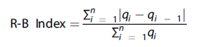
where qi is the mean daily flow on any given day of year (DOY) and qi-1 is the mean daily flow on the previous day and n is the number of days in the specified period (annual, snowmelt-dominated, rain-dominated). A lower R-B value indicates a less flashy hydrograph, and a higher R-B value indicates a flashier hydrograph. 

First, daily discharge and precipitation data were grouped by water year to calculate the annual sum and average. Then, the RB-index was calculated using daily discharge data for each water year and discharge-source period. 

In [ ]:
#Calculate total discharge per year -- group by year and sum.
dfannualsum = dfQprcp.groupby('water_year')[['Q.m3s', 'PRCP.mm', 'SNOW', 'perc_snow']].sum()
dfannualavg = dfQprcp.groupby('water_year')[['Q.m3s', 'PRCP.mm', 'SNOW','perc_snow']].mean()

#Calculate R-B index: first for when n = each water year (365 days): qi - (qi -1) / qi --> summed across water year.
#Index: the sum (e.g., across a water year) of the absolute value of day to day changes in mean daily flow divided by total discharge during a time interval (e.g., water year)
#For each wate r year
dfQprcp['Qdiff'] = abs(dfQprcp['Q.m3s'].diff()) #in dfQprcp calculate the absolute value of day to day changes in mean daily flow
dfannualsum['Qdiffsum'] = dfQprcp.groupby('water_year')[['Qdiff']].sum()
dfannualsum['RB'] = dfannualsum['Qdiffsum']/dfannualsum['Q.m3s']

#Calc RB index for each vernal window period 
dfQprcp['Qdiff'] = abs(dfQprcp['Q.m3s'].diff()) #in dfQprcp calculate the absolute value of day to day changes in mean daily flow
dfvernalRB = dfQprcp.groupby(['water_year', 'Vernal_Window'])[['Qdiff']].sum()
dfvernalRB['SumQm3s'] = dfQprcp.groupby(['water_year', 'Vernal_Window'])[['Q.m3s']].sum()
dfvernalRB['RB'] = dfvernalRB['Qdiff']/dfvernalRB['SumQm3s']
dfvernalRB.reset_index(inplace=True)
dfvernalRB = dfvernalRB.set_index('water_year', drop=True, append=False, inplace=False, verify_integrity=False)
dfvernalRB_snow = dfvernalRB.loc[dfvernalRB.Vernal_Window == "Snowmelt",] #filter out vernal period only
dfvernalRB_rain = dfvernalRB.loc[dfvernalRB.Vernal_Window == "Rain",] #filter out vernal period only

display(dfvernalRB_snow)
display(dfvernalRB_rain)

### 2.5 Hydrograph shape separation

Following methods described in Creed et al. (2015) and Grogan et al. (2020), a series of percentiles were calculated for cumulative discharge during the snowmelt and rain-dominated periods. Discharge data for each period were pooled across all years and the 50th percentile was calculated to estimate the center of mass; the 10th, 20th, and 25th percentiles were calculated to characterize changes to the beginning of each period’s hydrograph; the 75th, 80th, and 90th percentiles were calculated to characterize changes at the end of each period’s hydrograph. To quantify changes in the timing of water flux for each year and period, the day of year (DOY) that had the nearest discharge value to the total cumulative percentile value was found for each percentile, and then the difference between each consecutive years DOY was calculated. A negative difference in DOY indicates that the portion of the hydrograph is shifting to an earlier date, a positive difference in DOY indicates that the portion of the hydrograph is shifting to a later date. Change to the shape of the hydrograph (e.g., sharpening or flattening) was estimated by calculating the number of days for each year and period that fell within a range of percentile values that captures the majority of data (10th – 90th, 20th – 80th, and 25th – 75th percentiles). If the number of days in each percentile range is decreasing, there is a narrowing of the hydrograph window and the hydrograph will display a more peaked distribution. In contrast, if the number of days in each percentile range in increasing, there is a widening of the hydrograph window and the hydrograph will display a more flattened distribution (Creed et al., 2015).

In [ ]:
#Hydrograph shape separation
#trim dataframe to start at first whole calendar year and end at last whole calendar year
start_date = pd.to_datetime('1991-01-01')  # analysis start date ('YYYY-MM-DD' format)
end_date = pd.to_datetime('2019-12-31') #analysis end date
dfQprcp_trim = dfQprcp[start_date:end_date] 

#calc cumulative sum for each year and vernal period
dfQPcumsum = dfQprcp_trim.groupby(['Year', 'Vernal_Window'])[['discharge', 'PRCP.mm']].cumsum()

#reassign DOY, Month, Season, VW, Year period
dfQPcumsum['Day_of_Year'] = pd.DatetimeIndex(dfQPcumsum.index).dayofyear #get DOY
dfQPcumsum['Month'] = pd.DatetimeIndex(dfQPcumsum.index).month #get month
dfQPcumsum['Season'] = np.where((dfQPcumsum.Month == 12) | (dfQPcumsum.Month == 1) | (dfQPcumsum.Month == 2), "Winter", 
                             np.where((dfQPcumsum.Month == 3) | (dfQPcumsum.Month == 4) | (dfQPcumsum.Month == 5), "Spring", 
                                      np.where((dfQPcumsum.Month == 6) | (dfQPcumsum.Month == 7) | (dfQPcumsum.Month == 8), "Summer", 
                                               np.where((dfQPcumsum.Month == 9) | (dfQPcumsum.Month == 10) | (dfQPcumsum.Month == 11), "Fall", ""))))
dfQPcumsum['Vernal_Window'] =  np.where((dfQPcumsum.Month == 1) | (dfQPcumsum.Month == 2) | (dfQPcumsum.Month == 3) | (dfQPcumsum.Month == 4) | (dfQPcumsum.Month == 5)
                             | (dfQPcumsum.Month == 6), "Snowmelt", "Rain")
dfQPcumsum['Year'] = pd.DatetimeIndex(dfQPcumsum.index).year #get the year

display(dfQPcumsum)


In [ ]:
#Calculate quantiles and subset by period
dfQPcumsum_quan = dfQPcumsum.groupby(['Vernal_Window'])[['discharge', 'PRCP.mm']].quantile([.10, .20, .25, .50, .75, .80, .90]).reset_index()
dfQP_quansnow = dfQPcumsum_quan.loc[dfQPcumsum_quan.Vernal_Window == "Snowmelt"]
dfQP_quanrain = dfQPcumsum_quan.loc[dfQPcumsum_quan.Vernal_Window == "Rain"]

display(dfQP_quansnow)
display(dfQP_quanrain)

In [ ]:
#Perform calculations on discharge data for snow-melt period 
dfQPcumsumsnow = dfQPcumsum.loc[dfQPcumsum.Vernal_Window == "Snowmelt"]
dfQcumsumsnow = dfQPcumsumsnow[['discharge', 'Day_of_Year', "Month", 'Season', 'Vernal_Window', "Year"]]

# Run for loop on cumsum snow discharge data:
dfs = []
for i in dfQP_quansnow.discharge:
    print(i)
    test = dfQPcumsumsnow.groupby(['Year'])['discharge'].apply(lambda x: find_nearest(x,i))
    print(test)
    dfs.append(test)
df_quan = pd.DataFrame(dfs, index = [.10, .20, .25, .50, .75, .80, .90])

#Get the rest of data for each quantile value
dfp = []
for yr in df_quan.columns:
    print(df_quan[yr])
    mergedData= pd.merge(df_quan[yr], dfQPcumsum[dfQPcumsum['Year'] ==yr], how='left' ,left_on=df_quan[yr], right_on='discharge').set_index(df_quan.index)
    dfp.append(mergedData)
    
df_quan_final = pd.concat(dfp)
df_quan_final = df_quan_final[['discharge', 'Day_of_Year', 'Month', 'Season', 'Vernal_Window', 'Year']]
df_quan_final = df_quan_final.reset_index()
df_quan_final.rename(columns={ df_quan_final.columns[0]: "quan" }, inplace = True)
df_quan_final = df_quan_final.set_index(['quan', 'Year'])


#Timing of water flux: Calculate the change in the day of year for when these percentiles were attained for each period x year
change = df_quan_final.groupby(['quan'])['Day_of_Year'].diff()
df_quan_change = pd.merge(df_quan_final, change, left_index=True, right_index=True)


#Shape of hydrograph: for each period x year, calculate the number of days over which a specific range in percentiles e.g., the number of days within the 10th to 90th percentiles, 20th to 80th percentiles (over time) 

#assign Y/N to whether Q belongs to above quantile ranges
dfQcumsumsnow['quan0.1_quan0.9'] = np.where((dfQcumsumsnow.discharge >= 5047) & (dfQcumsumsnow.discharge <= 75199) , "Y", 'N') 
dfQcumsumsnow['quan0.2_quan0.8'] = np.where((dfQcumsumsnow.discharge >= 10143) & (dfQcumsumsnow.discharge <= 65392.9) , "Y", 'N') 
dfQcumsumsnow['quan0.25_quan0.75'] = np.where((dfQcumsumsnow.discharge >= 12832.8) & (dfQcumsumsnow.discharge <= 60015.1) , "Y", 'N') 

display(dfQcumsumsnow)

#sum (or get the length) of occurrences that fall into each bin ^ (Y = falls into category)
dfQbins1 = dfQcumsumsnow.groupby(['Year'])['quan0.1_quan0.9'].value_counts()
dfQbins2 = dfQcumsumsnow.groupby(['Year'])['quan0.2_quan0.8'].value_counts()
dfQbins3 = dfQcumsumsnow.groupby(['Year'])['quan0.25_quan0.75'].value_counts()

#%%Final Discharge-SNOWmelt outputs
df_quan_changeQsnow = df_quan_change
dfQbins1_Qsnow = dfQbins1
dfQbins2_Qsnow = dfQbins2
dfQbins3_Qsnow = dfQbins3

display(dfQbins1_Qsnow)
display(dfQbins2_Qsnow)
display(dfQbins3_Qsnow)

In [ ]:
#Perform calculations on discharge data for rain period 
dfQPcumsumrain = dfQPcumsum.loc[dfQPcumsum.Vernal_Window == "Rain"]
dfQcumsumrain = dfQPcumsumrain[['discharge', 'Day_of_Year', "Month", 'Season', 'Vernal_Window', "Year"]]

#%% Run for loop on cumsum rain discharge data:
dfs = []
for i in dfQP_quanrain.discharge:
    print(i)
    test = dfQPcumsumrain.groupby(['Year'])['discharge'].apply(lambda x: find_nearest(x,i))
    print(test)
    dfs.append(test)
df_quan = pd.DataFrame(dfs, index = [.10, .20, .25, .50, .75, .80, .90])

#Get the rest of data for each quantile value
dfp = []
for yr in df_quan.columns:
    print(df_quan[yr])
    mergedData= pd.merge(df_quan[yr], dfQPcumsum[dfQPcumsum['Year'] ==yr], how='left' ,left_on=df_quan[yr], right_on='discharge').set_index(df_quan.index)
    dfp.append(mergedData)
    
df_quan_final = pd.concat(dfp)
df_quan_final = df_quan_final[['discharge', 'Day_of_Year', 'Month', 'Season', 'Vernal_Window', 'Year']]
df_quan_final = df_quan_final.reset_index()
df_quan_final.rename(columns={ df_quan_final.columns[0]: "quan" }, inplace = True)
df_quan_final = df_quan_final.set_index(['quan', 'Year'])

#Timing of water flux: Calculate the change in the day of year for when these percentiles were attained for each period x year
change = df_quan_final.groupby(['quan'])['Day_of_Year'].diff()
df_quan_change = pd.merge(df_quan_final, change, left_index=True, right_index=True)


#Shape of hydrograph: for each period x year, calculate the number of days over which a specific range in percentiles e.g., the number of days within the 10th to 90th percentiles, 20th to 80th percentiles (over time) 

#assign Y/N to whether Q belongs to above quantile ranges
dfQcumsumrain['quan0.1_quan0.9'] = np.where((dfQcumsumrain.discharge >= 760.10) & (dfQcumsumrain.discharge <= 31054.99) , "Y", 'N') 
dfQcumsumrain['quan0.2_quan0.8'] = np.where((dfQcumsumrain.discharge >= 1508.32) & (dfQcumsumrain.discharge <= 19910.0) , "Y", 'N') 
dfQcumsumrain['quan0.25_quan0.75'] = np.where((dfQcumsumrain.discharge >= 2045.54) & (dfQcumsumrain.discharge <= 16305.225) , "Y", 'N') 

#sum (or get the length) of occurrences that fall into each bin ^ (Y = falls into category)
dfQbins1 = dfQcumsumrain.groupby(['Year'])['quan0.1_quan0.9'].value_counts()
dfQbins2 = dfQcumsumrain.groupby(['Year'])['quan0.2_quan0.8'].value_counts()
dfQbins3 = dfQcumsumrain.groupby(['Year'])['quan0.25_quan0.75'].value_counts()

#Final Discharge-rainmelt outputs
df_quan_changeQrain = df_quan_change
dfQbins1_Qrain = dfQbins1
dfQbins2_Qrain = dfQbins2
dfQbins3_Qrain = dfQbins3

In [ ]:
#Run summary statistics for the snow and rain period discharge outputs
snow_avg  = df_quan_changeQsnow.groupby('quan')['Day_of_Year_y'].mean()
snow_avg = pd.DataFrame(snow_avg)
snow_se = df_quan_changeQsnow.groupby('quan')['Day_of_Year_y'].std()
snow_se = pd.DataFrame(snow_se)

rain_avg  = df_quan_changeQrain.groupby('quan')['Day_of_Year_y'].mean()
rain_avg = pd.DataFrame(rain_avg)
rain_se = df_quan_changeQrain.groupby('quan')['Day_of_Year_y'].std()
rain_se = pd.DataFrame(rain_se)


In [ ]:
df_quan_changeQsnow = df_quan_changeQsnow.reset_index()
df_quan_changeQrain = df_quan_changeQrain.reset_index()

snow10 = df_quan_changeQsnow.loc[df_quan_changeQsnow.quan == 0.1]
rain10 = df_quan_changeQrain.loc[df_quan_changeQrain.quan == 0.1]
snow20 = df_quan_changeQsnow.loc[df_quan_changeQsnow.quan == 0.2]
rain20 = df_quan_changeQrain.loc[df_quan_changeQrain.quan == 0.2]
snow25 = df_quan_changeQsnow.loc[df_quan_changeQsnow.quan == 0.25]
rain25 = df_quan_changeQrain.loc[df_quan_changeQrain.quan == 0.25]
snow50 = df_quan_changeQsnow.loc[df_quan_changeQsnow.quan == 0.5]
rain50 = df_quan_changeQrain.loc[df_quan_changeQrain.quan == 0.5]
snow75 = df_quan_changeQsnow.loc[df_quan_changeQsnow.quan == 0.75]
rain75 = df_quan_changeQrain.loc[df_quan_changeQrain.quan == 0.75]
snow80 = df_quan_changeQsnow.loc[df_quan_changeQsnow.quan == 0.8]
rain80 = df_quan_changeQrain.loc[df_quan_changeQrain.quan == 0.8]
snow90 = df_quan_changeQsnow.loc[df_quan_changeQsnow.quan == 0.9]
rain90 = df_quan_changeQrain.loc[df_quan_changeQrain.quan == 0.9]


In [ ]:
#%% plotting the number of days within each range of data. using data:
# RAIN = dfQbins1_Qrain, dfQbins2_Qrain, dfQbins3_Qrain
#SNOW = dfQbins1_Qsnow, dfQbins2_Qsnow, dfQbins3_Qsnow

dfQbins1_Qrain = pd.DataFrame(dfQbins1_Qrain)
dfQbins1_Qrain.index.set_names(["Year", "Condition"], inplace=True)
dfQbins1_Qrain = dfQbins1_Qrain.reset_index()
rain1090 = dfQbins1_Qrain.loc[dfQbins1_Qrain.Condition == 'Y']
rain1090avg = rain1090['quan0.1_quan0.9'].mean()
slope1090rain, intercept1090rain = np.polyfit(rain1090['Year'], rain1090['quan0.1_quan0.9'], 1)

dfQbins2_Qrain = pd.DataFrame(dfQbins2_Qrain)
dfQbins2_Qrain.index.set_names(["Year", "Condition"], inplace=True)
dfQbins2_Qrain = dfQbins2_Qrain.reset_index()
rain2080 = dfQbins2_Qrain.loc[dfQbins2_Qrain.Condition == 'Y']
rain2080avg = rain2080['quan0.2_quan0.8'].mean()
slope2080rain, intercept2080rain = np.polyfit(rain2080['Year'], rain2080['quan0.2_quan0.8'], 1)

dfQbins3_Qrain = pd.DataFrame(dfQbins3_Qrain)
dfQbins3_Qrain.index.set_names(["Year", "Condition"], inplace=True)
dfQbins3_Qrain = dfQbins3_Qrain.reset_index()
rain2575 = dfQbins3_Qrain.loc[dfQbins3_Qrain.Condition == 'Y']
rain2575avg = rain2575['quan0.25_quan0.75'].mean()
slope2575rain, intercept2575rain = np.polyfit(rain2575['Year'], rain2575['quan0.25_quan0.75'], 1)

#same as above for snow
dfQbins1_Qsnow = pd.DataFrame(dfQbins1_Qsnow)
dfQbins1_Qsnow.index.set_names(["Year", "Condition"], inplace=True)
dfQbins1_Qsnow = dfQbins1_Qsnow.reset_index()
snow1090 = dfQbins1_Qsnow.loc[dfQbins1_Qsnow.Condition == 'Y']
snow1090avg = snow1090['quan0.1_quan0.9'].mean()
slope1090snow, intercept1090snow = np.polyfit(snow1090['Year'], snow1090['quan0.1_quan0.9'], 1)

dfQbins2_Qsnow = pd.DataFrame(dfQbins2_Qsnow)
dfQbins2_Qsnow.index.set_names(["Year", "Condition"], inplace=True)
dfQbins2_Qsnow = dfQbins2_Qsnow.reset_index()
snow2080 = dfQbins2_Qsnow.loc[dfQbins2_Qsnow.Condition == 'Y']
snow2080avg = snow2080['quan0.2_quan0.8'].mean()
slope2080snow, intercept2080snow = np.polyfit(snow2080['Year'], snow2080['quan0.2_quan0.8'], 1)

dfQbins3_Qsnow = pd.DataFrame(dfQbins3_Qsnow)
dfQbins3_Qsnow.index.set_names(["Year", "Condition"], inplace=True)
dfQbins3_Qsnow = dfQbins3_Qsnow.reset_index()
snow2575 = dfQbins3_Qsnow.loc[dfQbins3_Qsnow.Condition == 'Y']
snow2575avg = snow2575['quan0.25_quan0.75'].mean()
slope2575snow, intercept2575snow = np.polyfit(snow2575['Year'], snow2575['quan0.25_quan0.75'], 1)

dfsloperain = pd.DataFrame(pd.Series([slope1090rain, slope2080rain, slope2575rain], index = ["10th-90th", "20th-80th", "25th-75th"]))
dfsloperain['slope'] = dfsloperain[0]

dfslopesnow = pd.DataFrame(pd.Series([slope1090snow, slope2080snow, slope2575snow], index = ["10th-90th", "20th-80th", "25th-75th"]))
dfslopesnow['slope'] = dfslopesnow[0]


### 3. Results

### 3.1 Cumulative discharge and precipitation

From 1990-2020 cumulative discharge and precipitation during the rain-dominated months (June - December) does not appear to change over time (Figure 3). There is considerable variability with both discharge and precipitation over time, however from 2010 to 2020, precipitation trends were steady whereas discharge trends were peaked (Figure 3). In contrast, cumulative discharge and precipitation in the snowmelt-dominated months (January - June) appear to be decreasing from around 2005 to 2020 (Figure 4). 


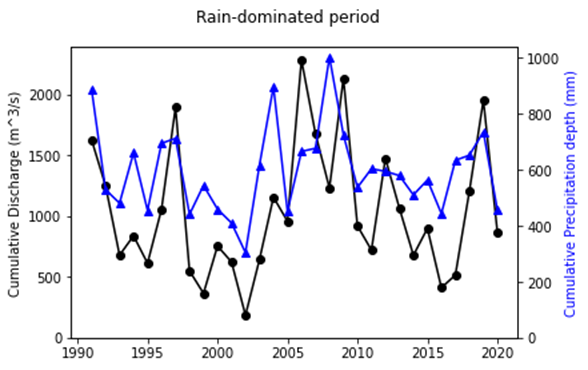
Figure 3. Cumulative discharge (black circles) and precipitation (blue triangles) for the rain-dominated period (July - December) from 1990 to 2020 in the Lamprey River watershed.
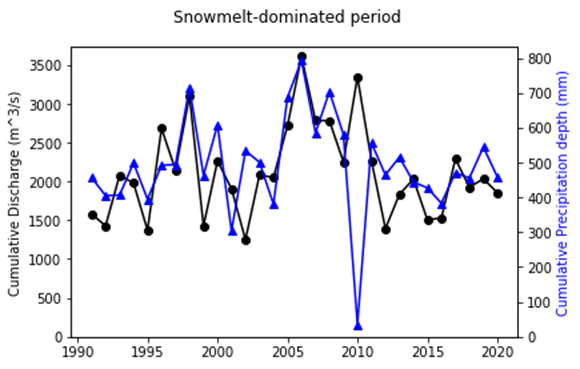
Figure 4. Cumulative discharge (black circles) and precipitation (blue triangles) for the snowmelt-dominated period (January - June) from 1990 to 2020 in the Lamprey River watershed.

### 3.2 Water year hydrographs

The water year hydrograph was visually assessed for shape and distribution using monthly means (Figure 5). Hydrograph shape is variable, with some years displaying single peaked freshet events in spring, and other years displaying multi-peaked events in winter and spring (Figure 5). For example, take hydrographs from 2014 and 2015 compared to 2016 and 2017 hydrographs: 2014 and 2015 display multipeaked winter-spring hydrographs suggesting multiple snowmelt events, whereas 2016 and 2017 display single peaked hydrographs.

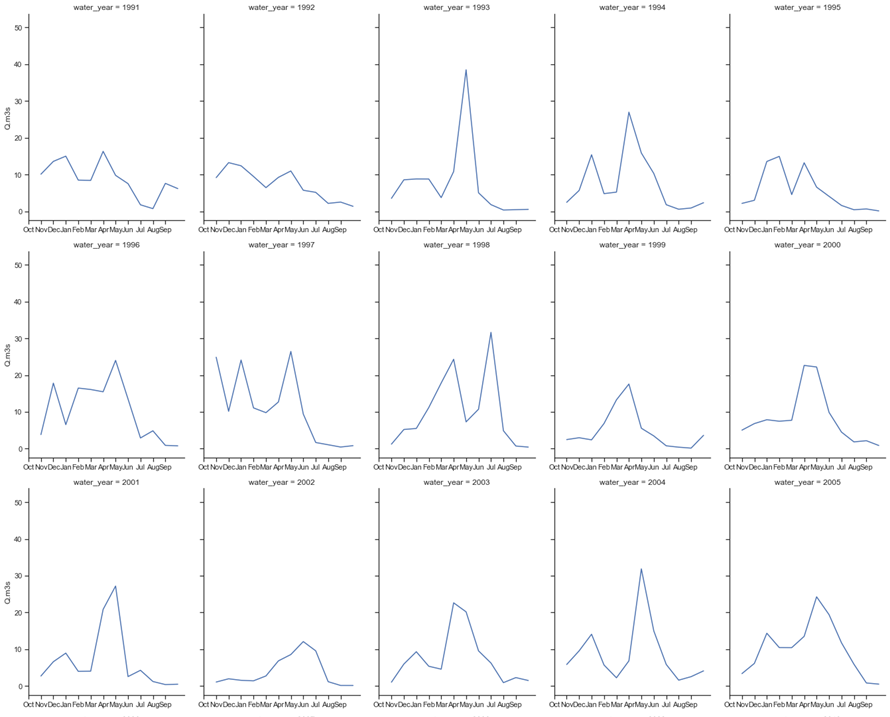
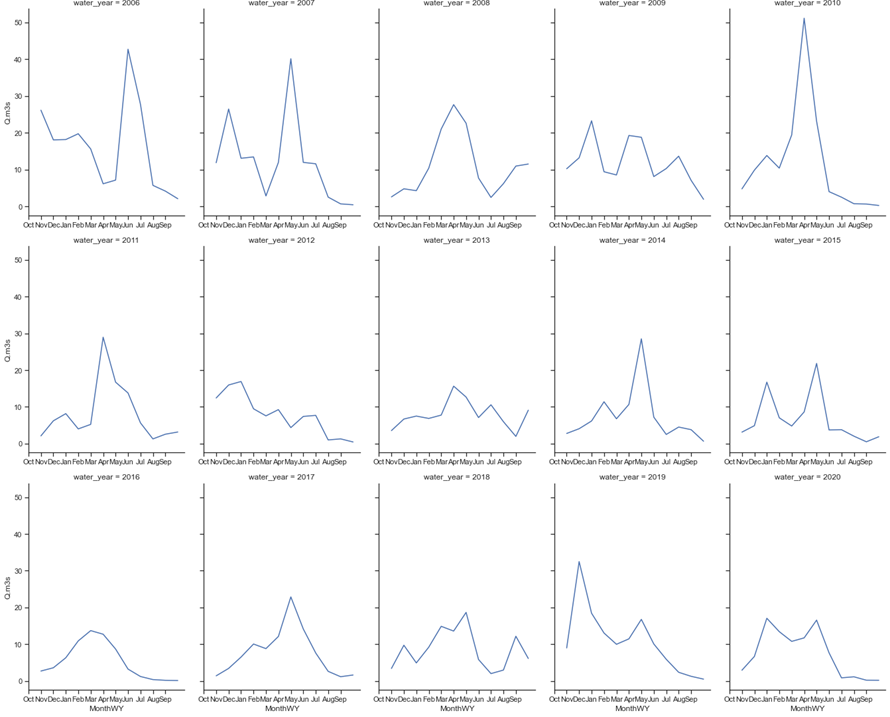
Figure 5. Water year hydrographs (monthly mean) from 1991 - 2020 for the Lamprey River.

### 3.3 R-B index inter-annual trend

The R-B index is a metric that is used to indicate how flashy, or variable, discharge is within a given time period. For the Lamprey River, from 1990 - 2020, the RB index ranged from 0.1 - 0.3. Higher RB indicies indicate flashier rivers. Figure 6 shows the R-B index for the Lamprey River for water years 1991 - 2020, and for within each water year the snowmelt and rainmelt dominant period. From these plots, there is no obvious trend in R-B index over time. That is, the Lamprey River does not seem to be experiencing more flashy conditions given the highly variable R-B indicies over time (Figure 6). 

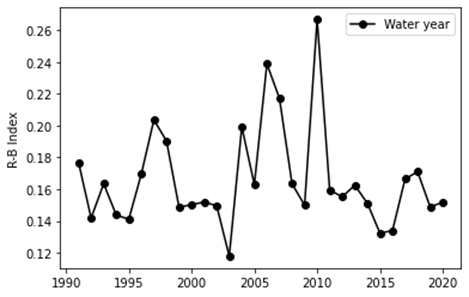
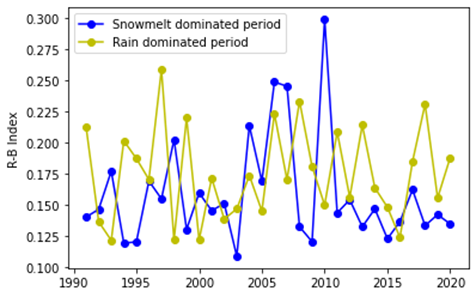
Figure 6. R-B index for each water year (top, black) and the snowmelt dominant (bottom, blue) and rain dominant (bottom, yellow) periods in each water year. 

### 3.4 R-B index as a function of snow depth

The amount of snow that falls within a given year may drive watersheds to become more flashy. Increased snowpack takes longer to melt due to the albedo effect, thus the watershed recieves a steady input of snowmelt water until air temperatures rise past the melting point at which point snow would melt rapidly and water would shunted into the river.
To test this theory the relationship between total snow deposition and RB index for the snowmelt dominant period was plotted (Figure 7), and a Pearsons correlation coefficient calculated. Pearsons correlation coefficient for RB ~ snow depth was -0.23, indicating a significant negative correlation between R-B flashiness index and snow depth. This finding makes sense as when a watershed recieves less snow, the snow albedo is reduced so the snow melts at a faster rate. Thus, the river is more likely to recieve many pulses of runoff during the snowmelt period. 

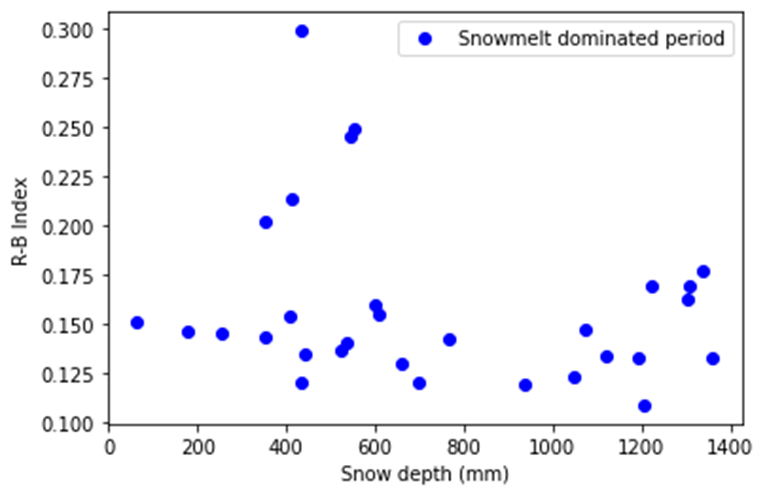
Figure 7. R-B index as a function of total snow precipitiation (mm) for each snowmelt dominant period. 

### 3.5 Hydrograph shape separation

Percentiles for the cumulative discharge for each each water year x rain-dominant (July - December; top) and snow dominant (January - June; bottom) period were found (Figure 8). Generally, the snowmelt dominant spanned a larger range of discharge (0 - 120,000 cfs) than the rain dominant period (0 - 9,000 cfs) (Figure 8). The snowmelt dominant period was more evenly distributed across discharge values whereas the rain dominant period had more low discharge values compared to high (Figure 8). The amount of snow in a given water year likely drives the cumulative discharge within the snowmelt period, which is highly variable across our dataset (Figure 7) and could explain the variable cumulative discharge distribution during the snowmelt period. As a result of differring frequency distributions, the cumulative discharge percentile values for the snowmelt period exceeded the rain period, and were more distributed throughout the data, whereas the rain period had the 10th, 20th, 25th, and 50th percentile values very close together (Figure 8)


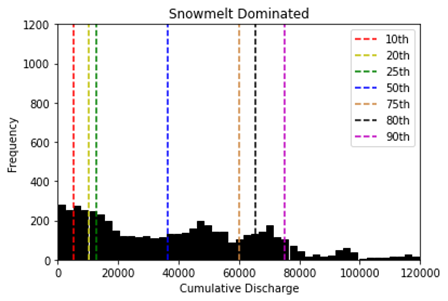 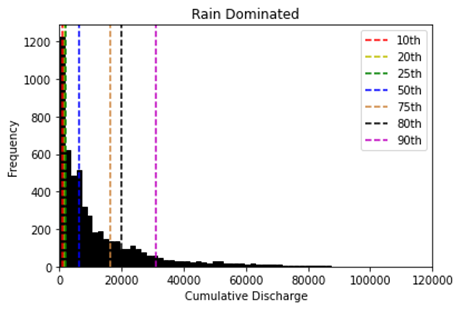

Figure 8. Frequency distribution of cumulative discharge for each water year x snow dominant (January - June; top) and rain-dominant (July - December; bottom) period. The vertical dashed lines represent the 10th, 20th, 25th, 50th, 75th, 80th and 90th percentiles for each frequency distribution.

### 3.5.1 Timing of water flux

The timing of water flux to the Lamprey River was assessed by finding the change in the DOY for each percentile in each period x water year. A negative change in DOY indicates that the water flux is shifting to earlier in the year, and a positive change in DOY indicates the water flux is shifting to later in the year. The 10th, 20th and 25th percentiles are indicative of the beginning of the rain or snow hydrograph, and the 75th, 80th, and 90th are indicative of the end of the rain or snow hydrograph. The average change in DOY was found for the data record (1990-2020) (Figure 9). The beginning of the snow and rain hydrograph are shifting to earlier in the year by about 0.5 to 1 day, respectively. The end of the snow hydrograph is also shifting earlier with the most dramatic average shift of -2 days for the 75th percentile (Figure 8). In contrast, the end of the rain hydrograph is shifting later in the year by on average 1-2 days (Figure 8). However, the change in DOY over time was found to be highly variable, and no obvious trends were found (Figure 10).  


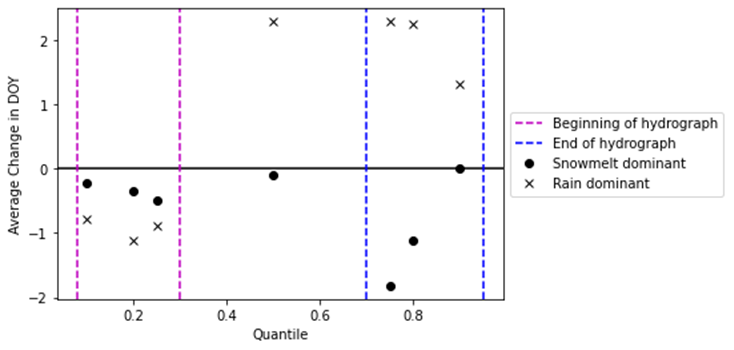
Figure 9. Average change in DOY for each cumulative percentile over time.


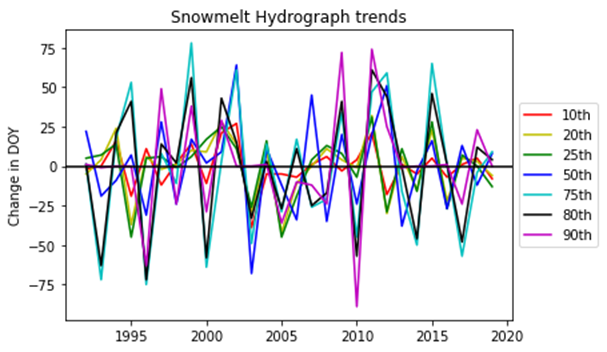
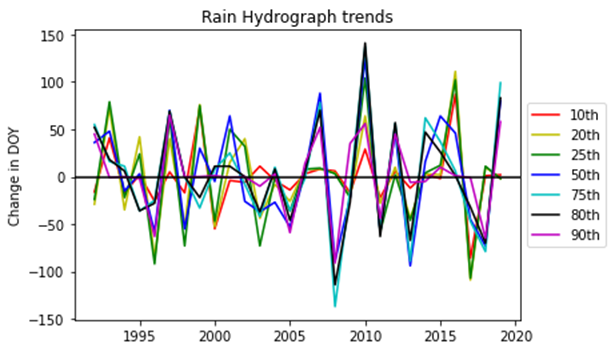
Figure 10. Change in DOY for each cumulative percentile over time.

### 3.5.1 Duration of water flux

The duration of the water flux was determined by the change in number of days that fall within a percentile range (10th - 90th, 20th - 80th, 25th - 75th). The regression slope for the number of days within each percentile over time (Figure 11) was found and plotted for each period (Figure 12). All percentiles had a generally widening pattern (e.g., positive slope or increase in the number of days within a percentile) (Figure 12). However, the rain hydrograph is widening at a faster rate than the snow hydrograph, indicating that the the rain hydrograph is becoming more flattened, or less peaked. Additionally, the duration of the snow pack hydrograph for the 20th - 80th percentile is also widening, however the 10th - 90th and 25th - 75th percentiles had slopes closer to 0, indicating no detectable trend over time (Figure 12). 


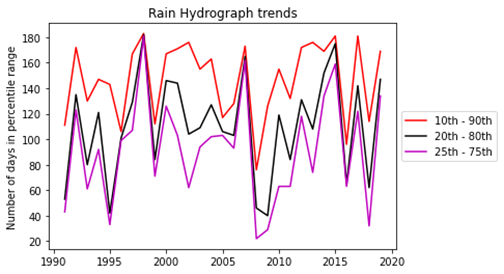
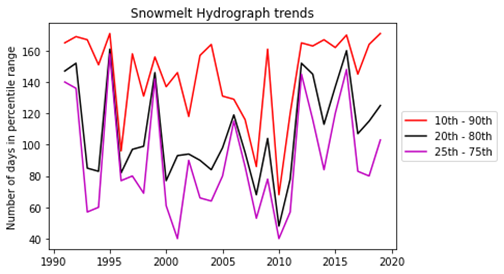
Figure 11. 


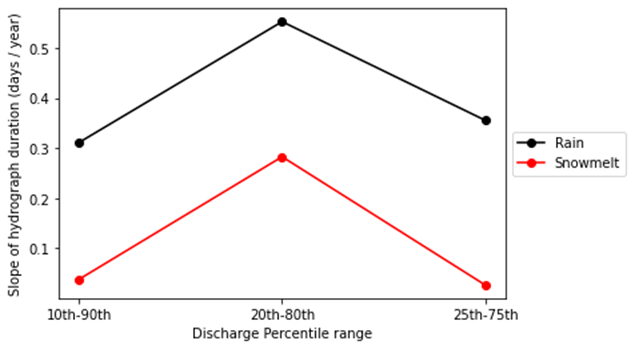
Figure 12. 



### 4. Discussion

RB index:
Lamprey River isn’t getting flashier over time BUT… 
There is a significant negative relationship between RB index and volume of snow: warmer winters = less snow = flashier river. 
Does appear that the Lamprey River watershed may also be experiencing less precipitation in general, which could counteract the flashy-ness hypothesis
Timing of water flux:
Beginning and end of snow hydrograph is earlier in year
Center of mass for snow hydrograph is same
Supports the hypothesis that protracting vernal window is changing discharge timing
Duration of water flux:
Rain hydrograph is widening over time (less peaked/flashy)
Snow hydrograph center of mass (20th – 80th) is widening over time (less peaked/flashy) with outliers displaying more extreme flashiness in some years
Contradicts the hypothesis that a protracting vernal window is increasing flashiness. 

What effect does earlier snowmelt but increased duration of snowmelt have on in-stream biogeochemical processing?
 

### 5. Conclusion

The shift towards a flashier winter-spring hydrograph can change the annual water distribution, in-stream biogeochemical processing and aquatic phenology (Contosta et al., 2017; Coble et al., 2019). Here, daily discharge data from the Lamprey River watershed in New Hampshire, USA were used to determine whether the shape of the hydrograph has changed from 1990 to 2020. Results from this study indicate XYZ.

### References

Baker, D.B., Richards, R.P., Loftus, T.T. and Kramer, J.W., 2004. A new flashiness index: Characteristics and applications to midwestern rivers and streams 1. JAWRA Journal of the American Water Resources Association, 40(2), pp.503-522.

Coble, A.A., Marcarelli, A.M. and Kane, E.S., 2019. Year-round measurements reveal seasonal drivers of nutrient uptake in a snowmelt-driven headwater stream. Freshwater Science, 38(1), pp.156-169.

Contosta, A.R., Adolph, A., Burchsted, D., Burakowski, E., Green, M., Guerra, D., Albert, M., Dibb, J., Martin, M., McDowell, W.H. and Routhier, M., 2017. A longer vernal window: the role of winter coldness and snowpack in driving spring transitions and lags. Global change biology, 23(4), pp.1610-1625.

Contosta, A.R., Casson, N.J., Garlick, S., Nelson, S.J., Ayres, M.P., Burakowski, E.A., Campbell, J., Creed, I., Eimers, C., Evans, C. and Fernandez, I., 2019. Northern forest winters have lost cold, snowy conditions that are important for ecosystems and human communities. Ecological Applications, 29(7), p.e01974.

Creed, I.F., Hwang, T., Lutz, B. and Way, D., 2015. Climate warming causes intensification of the hydrological cycle, resulting in changes to the vernal and autumnal windows in a northern temperate forest. Hydrological Processes, 29(16), pp.3519-3534.

Grogan, D.S., Burakowski, E.A. and Contosta, A.R., 2020. Snowmelt control on spring hydrology declines as the vernal window lengthens. Environmental Research Letters, 15(11), p.114040.

Hayhoe, K., Wake, C., Anderson, B., Liang, X.Z., Maurer, E., Zhu, J., Bradbury, J., DeGaetano, A., Stoner, A.M. and Wuebbles, D., 2008. Regional climate change projections for the Northeast USA. Mitigation and Adaptation Strategies for Global Change, 13(5), pp.425-436.

Wymore, A.S., Shattuck, M.D., Potter, J.D., Snyder, L. and McDowell, W.H., 2021. The Lamprey River Hydrological Observatory: Suburbanization and changing seasonality. Hydrological Processes, 35(4), p.e14131.